- [ ] revision
- [x] visualizacion (hacer plots de varios, util para evaluacion)
- [ ] resumen estadistico
- [ ] atipicos
- [ ] necesidad de transformacion
- [ ] transformacion
- [ ] encontrar buen algoritmo y hiperparametros
- [ ] evaluacion
- [ ] analisis
---

In [1]:
from utils.mnist_reader import load_mnist
#import p1utils
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from  sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering, MeanShift, OPTICS, estimate_bandwidth, SpectralClustering
from sklearn.decomposition import PCA
import sklearn.manifold
from  sklearn.model_selection import GridSearchCV
import numpy as np
from time import time
import umap
import torch
from torch import nn, tensor, optim
from torch.utils.data import DataLoader
import pandas as pd

## 1. Analisis exploratorio inicial

In [2]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')
X_train, X_dev = X_train[:50000], X_train[50000:]
y_train, y_dev = y_train[:50000], y_train[50000:]

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_dev: {X_dev.shape}, y_dev: {y_dev.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (50000, 784), y_train: (50000,)
X_dev: (10000, 784), y_dev: (10000,)
X_test: (10000, 784), y_test: (10000,)


#### 1.1 Visualización

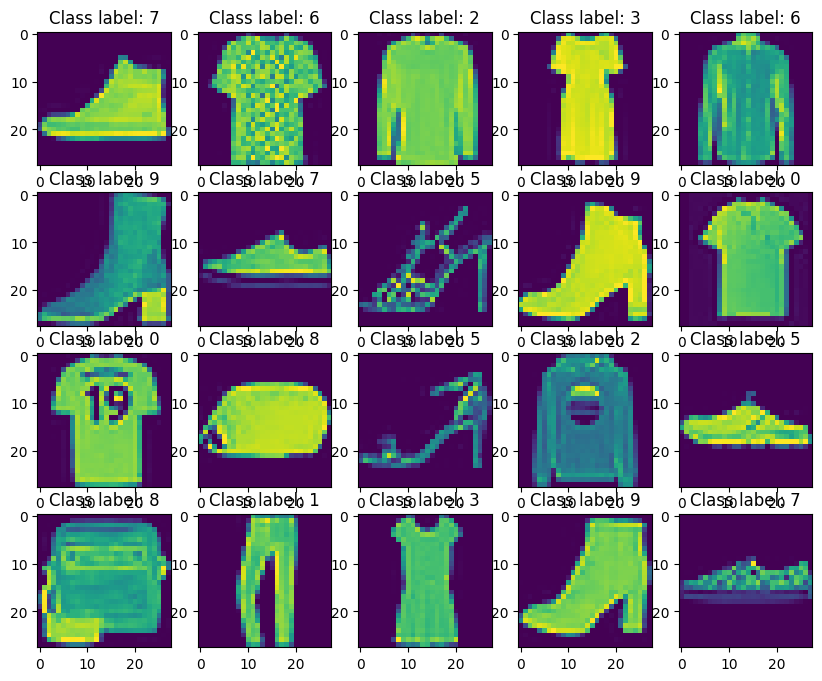

In [9]:
def plot20random()
indexes = np.random.choice(len(X_train),20)
plt.figure(figsize=(10, 8))
for i, index in enumerate(indexes):
    plt.subplot(4,5,i+1)
    plt.title(f'Class label: {y_train[index]}')
    plt.imshow(np.resize(X_train[index],(28,28)))
    
plt.show()


Vemos el dataset, consta de ropa y las clases oficialmente son:
 | Clase | Tipo de prenda |
| --- | --- |
| 0 | Camiseta |
| 1 | Pantalón |
| 2 | Jersei |
| 3 | Vestido |
| 4 | Abrigo |
| 5 | Sandalia |
| 6 | Camisa |
| 7 | Tenis |
| 8 | Bolso |
| 9 | Bota |

Como es evidente, no todas las clases son igual de parecidas entre si ni distintas con respecto a las otras. Los Jerseis serán bastante parecidos entre sí mientras que las sandalias pueden ser más distintas (formas realmente diferentes). Esto tiene que ver con el concepto de $Eps$ (https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf), que esperaríamos que varíe de cluster a cluster (lo cual dificulta el problema). 

También esperariamos que las camisas sean más parecidas a las camisetas que a los tenis, e incluso podría ser razonable confundir camisas con camisetas, por ejemplo. Esto es razonable que ocurra pero puede acarrear la consecuencia de confundir clases en solo una. 

Aprovechamos este momento para discutir _filosóficamente_ el número de clusters apropiado. Si bien parece razonable adoptar las clases originales ($k=10$) como buenas, probablemente para aquellos que se dediquen al textil puedan ser pocas y ellos destacarían quizás 15 o 20, y por otro lado mi padre igual solo distinguiría 4: zapatos, ropa de arriba, ropa de abajo o accesorios. Por tanto como sólo es una práctica y no debemos clusterizar con ningún objetivo en concreto (lo cual sería lo propio), de ahora en adelante usaremos métricas que supondrán que $k=10$ es lo ideal al pasarle $y_{train}$. Esto, no obstante, podría no ser lo ideal para alguna aplicición. Se volverá a tratar este punto en la sección $1.4$ .

#### 1.2 Balanceo de datos

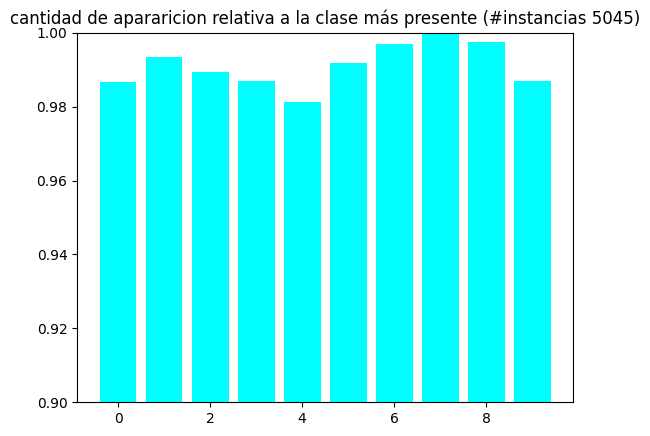

In [36]:
counts, _ = np.histogram(y_train)
plt.bar(range(len(counts)), counts/max(counts) ,color='cyan')
plt.ylim((0.9,1))
plt.title(f'cantidad de apararicion relativa a la clase más presente (#instancias {max(counts)})');

En el anterior gráfico se muestra la presencia relativa (número de instancias) para cada etiqueta con  respecto a la clase con más instancias. Vemos que están atípica(_artificial_)mente balanceados. Esto es bueno a priori. Decimos a priori porque no importa que hayan 5000 camisetas si son todas muy parecidas

In [37]:
reducer = umap.UMAP()
X_train_reduced = reducer.fit_transform(X_train)
hdbscan1000, hdbscan100, hdbscan10  = HDBSCAN(min_cluster_size = 1000), HDBSCAN(min_cluster_size = 100), HDBSCAN(min_cluster_size = 10)
labelsHDBSCAN1000, labelsHDBSCAN100, labelsHDBSCAN10 = hdbscan1000.fit_predict(X_train_reduced), hdbscan100.fit_predict(X_train_reduced), hdbscan10.fit_predict(X_train_reduced)

/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 1.3 Atípicos

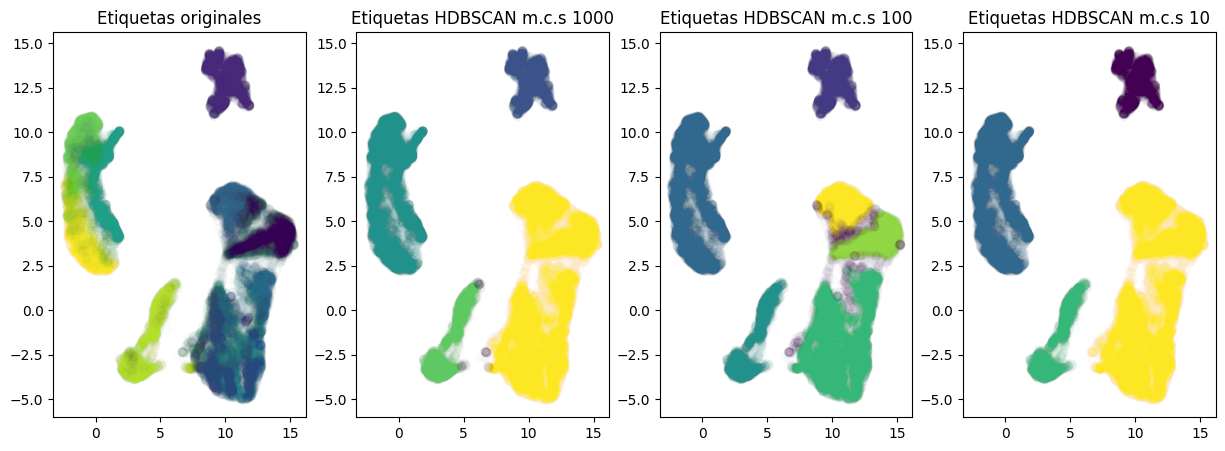

In [51]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.title('Etiquetas originales')
plt.scatter(X_train_reduced[:,0],X_train_reduced[:,1],alpha=1e-2,c=y_train)
plt.subplot(1,4,2)
plt.title('Etiquetas HDBSCAN m.c.s 1000')
plt.scatter(X_train_reduced[:,0],X_train_reduced[:,1],alpha=1e-2,c=labelsHDBSCAN1000)
plt.subplot(1,4,3)
plt.title('Etiquetas HDBSCAN m.c.s 100')
plt.scatter(X_train_reduced[:,0],X_train_reduced[:,1],alpha=1e-2,c=labelsHDBSCAN100)
plt.subplot(1,4,4)
plt.title('Etiquetas HDBSCAN m.c.s 10')
plt.scatter(X_train_reduced[:,0],X_train_reduced[:,1],alpha=1e-2,c=labelsHDBSCAN10);

En el gráfico Anterior vemos los datos reducidos a dos dimensiones con UMAP (https://arxiv.org/pdf/1802.03426). Sobre esos datos hemos clusterizado usando HDBSCAN (https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) porque bajo su definición de _cluster_ se considera el concepto de _ruído_ o _anomalía_. Probamos el hiperparámetro `min_cluster_size` con valores $10^i \; | \; i \in \{1,2,3\}$, y vemos a ojo que 100 lo hace razonablemente bien. Escogemos entonces las etiquetas producidas por esa clusterización y a continuación ploteamos unas cuantas prentas de la clase _ruido_ ($-1$).

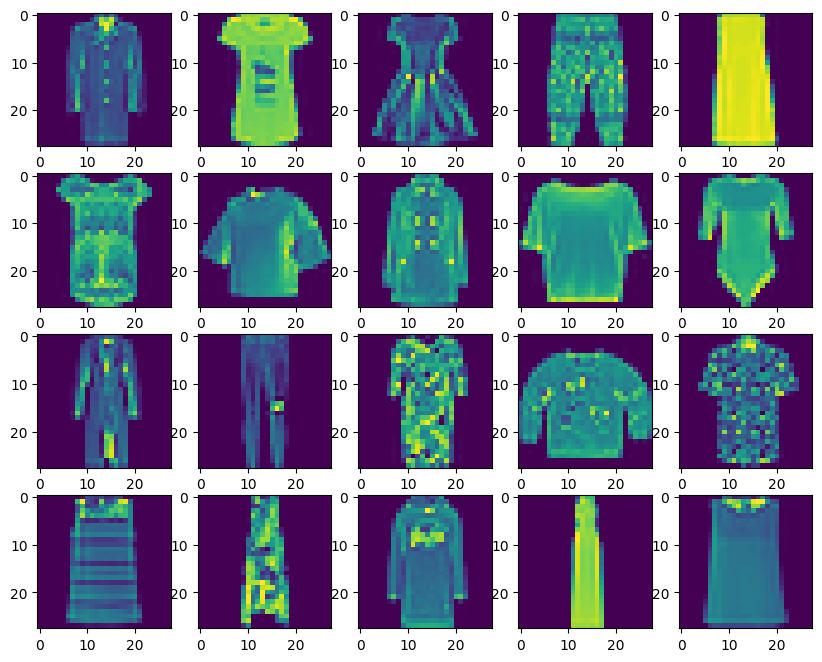

In [50]:
anomalies = np.where(labelsHDBSCAN100 == -1)[0]
indexes = np.random.choice(anomalies,20)
plt.figure(figsize=(10, 8))
for i, index in enumerate(indexes):
    plt.subplot(4,5,i+1)
    #plt.title(f'Class label: {y_train[index]}')
    plt.imshow(np.resize(X_train[index],(28,28)))
plt.show()

De la celda anterior se ven los elementos clasificados como ruído. Algunos son reconociblemente ruidosos pero para muchos tenemos que hacer el esfuerzo e imaginarnos que somos una máquina para reconocer lo ruidosos que son. Recomiendamos subir arriba para comparar con las prendas que no eran ruidosas (o por lo menos fueron escogidas aleatoriamente).

#### 1.4 (Re) Discusión de número de clusters

Ahora que hemos explorado ligeramente la distribución de los datos en el espacio-de-pixeles-reducido-por-umap, vamos a aprovechar para retomar la discusión del número apropiado de clusters. En concreto vamos a explorar la patata-gausiana de abajo a la izquierda, que originalmente son muchas clases pero no todos los HDBSCANes concordaban.

In [56]:
corners = np.array([
    [7, -2.5],  
    [10, 7],  
    [12, -5],  
    [15, 5],  
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

inv_transformed_points = reducer.inverse_transform(test_pts)

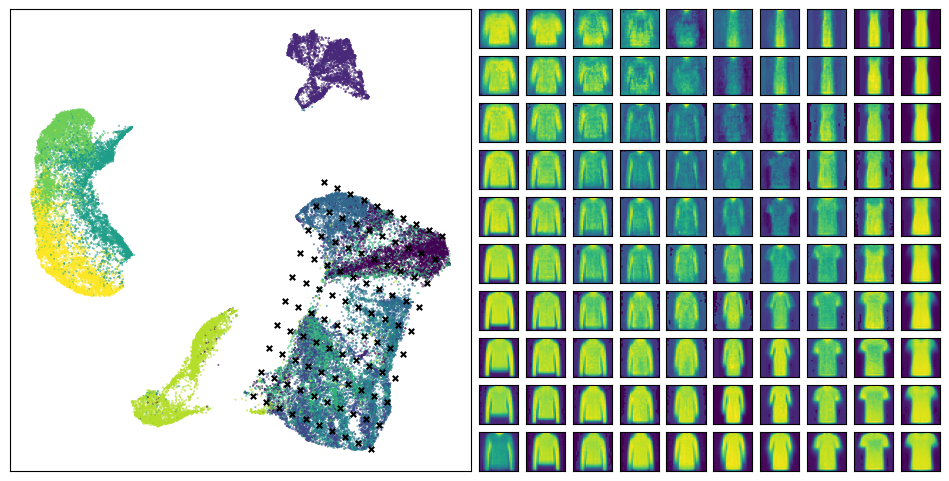

In [62]:
# código fusilado de https://umap-learn.readthedocs.io/en/latest/inverse_transform.html

fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])


scatter_ax.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1],
                   c=y_train.astype(np.int32),  s=0.1)
scatter_ax.set(xticks=[], yticks=[])

scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])

En la grafica anterior se samplearon puntos en el espacio reducido y se generaron las correspondientes imágenes en el espacio de píxeles.

Si bien originalmente podríamos pensar que toda esa patata era un mismo cluster (la division a ojo de puntos en 2d parecía sugerirlo) ahora vemos que no. Que a lo largo de la patata hay distintos tipos de prendas. Fácilemente se pueden nombrar: vestidos de tubo, jerseis, camisetas de manga corta, blusas y sudaderas. Por otro lado también sería noble nombrarlos a todos como _ropa de arriba_, y entonces toda la patata sí sería un único cluster.

Adicionalmente se puede comentar de esta gráfica que la representación de los datos después de aplicar umap y reducirlo a dos dimensiones no es mala del todo. En lo que prosigue se usará

/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[9.21838   5.348615  2.410259  6.491689  6.3016953 4.5192323 5.3676987
 5.785854  5.2402153 4.897839 ]


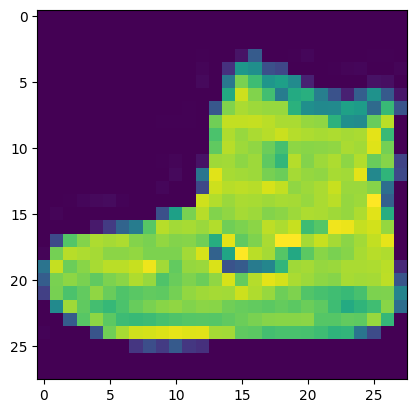

In [6]:
X_train_10D = umap.UMAP( n_components=10).fit_transform(X_train)
# vemos como queda el primer elemento
print(X_train_10D[0])
plt.imshow(np.resize(X_train[0],(28,28)));

#### 1.4 Intento de transformación con un autoencoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def trainModel(self, train_loader):
        criterion = nn.MSELoss()  # Mean Squared Error Loss
        lr = 3e-3
        optimizer = optim.Adam(self.parameters(), lr=lr)
        num_epochs = 2000
        device = torch.device("mps")
        self.to(device)
        losses = []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for batch_idx, data in enumerate(train_loader):
                # Forward pass
                
                data = data.to(device)
                output = self.forward(data)
                loss = criterion(output, data)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                running_loss += loss.item()
                losses.append(loss.item)
            if epoch%5 == 0: 
                torch.save(self.state_dict(), 'modelParams')
                if epoch%3 == 0:
                    self.plotCurrentAbility()
                
            #print(f">>epoch [{epoch}], Loss: {running_loss/len(train_loader):.4f}")


                
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
            
        plt.plot(losses)


    def plotCurrentAbility(self):
        self.eval
        self.to('cpu')
        
        plt.subplot(3,2,1)
        plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][0].detach().numpy(),(28,28)))
        plt.subplot(3,2,2)
        plt.imshow(np.reshape(X_train[0],(28,28)))
        plt.subplot(3,2,3)
        plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][1].detach().numpy(),(28,28)))
        plt.subplot(3,2,4)
        plt.imshow(np.reshape(X_train[1],(28,28)))
        plt.subplot(3,2,5)
        plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][2].detach().numpy(),(28,28)))
        plt.subplot(3,2,6)
        plt.imshow(np.reshape(X_train[2],(28,28)))

        self.train()
        self.to('mps')
        

def toNNformat(x):
    xformated = tensor(x).float() / 255.0
    return xformated.unsqueeze(0)

In [4]:
autoencoder = Autoencoder()

In [69]:
X_train_tensor = toNNformat(X_train)
train_loader = DataLoader(X_train_tensor, batch_size=128, shuffle=True)

In [72]:
autoencoder.load_state_dict(torch.load('modelParams'))
autoencoder.trainModel(train_loader)

Epoch [1/2000], Loss: 0.1927
Epoch [2/2000], Loss: 0.1894
Epoch [3/2000], Loss: 0.1855
Epoch [4/2000], Loss: 0.1809
Epoch [5/2000], Loss: 0.1760
Epoch [6/2000], Loss: 0.1708
Epoch [7/2000], Loss: 0.1657
Epoch [8/2000], Loss: 0.1616
Epoch [9/2000], Loss: 0.1584
Epoch [10/2000], Loss: 0.1555
Epoch [11/2000], Loss: 0.1531
Epoch [12/2000], Loss: 0.1511
Epoch [13/2000], Loss: 0.1495
Epoch [14/2000], Loss: 0.1480
Epoch [15/2000], Loss: 0.1465
Epoch [16/2000], Loss: 0.1449
Epoch [17/2000], Loss: 0.1431
Epoch [18/2000], Loss: 0.1410
Epoch [19/2000], Loss: 0.1389
Epoch [20/2000], Loss: 0.1368
Epoch [21/2000], Loss: 0.1348
Epoch [22/2000], Loss: 0.1330
Epoch [23/2000], Loss: 0.1314
Epoch [24/2000], Loss: 0.1301
Epoch [25/2000], Loss: 0.1288
Epoch [26/2000], Loss: 0.1275
Epoch [27/2000], Loss: 0.1262
Epoch [28/2000], Loss: 0.1247
Epoch [29/2000], Loss: 0.1232
Epoch [30/2000], Loss: 0.1215
Epoch [31/2000], Loss: 0.1198
Epoch [32/2000], Loss: 0.1180
Epoch [33/2000], Loss: 0.1162
Epoch [34/2000], Lo


KeyboardInterrupt



Error in callback <function flush_figures at 0x142d64360> (for post_execute), with arguments args (),kwargs {}:


Traceback (most recent call last):
  File "/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/IPython/core/events.py", line 82, in trigger
    func(*args, **kwargs)
    ~~~~^^^^^^^^^^^^^^^^^
  File "/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/matplotlib_inline/backend_inline.py", line 126, in flush_figures
    return show(True)
  File "/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
    ~~~~~~~^
        figure_manager.canvas.figure,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/pepe/carrera/3/2/ma2/ma2/lib/python3.13/site-packages/IPython/core/display_functions.py", line 278, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
                           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

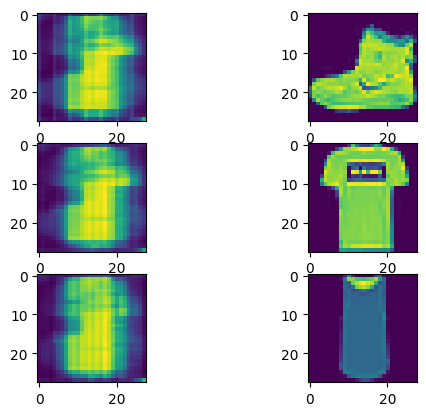

In [5]:
autoencoder.load_state_dict(torch.load('modelParams'))


autoencoder.eval
autoencoder.to('cpu')

plt.subplot(3,2,1)
plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][0].detach().numpy(),(28,28)))
plt.subplot(3,2,2)
plt.imshow(np.reshape(X_train[0],(28,28)))
plt.subplot(3,2,3)
plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][1].detach().numpy(),(28,28)))
plt.subplot(3,2,4)
plt.imshow(np.reshape(X_train[1],(28,28)))
plt.subplot(3,2,5)
plt.imshow(np.reshape(autoencoder(toNNformat(X_train))[0][2].detach().numpy(),(28,28)))
plt.subplot(3,2,6)
plt.imshow(np.reshape(X_train[2],(28,28)))

Como se puede ver, el autoencoder después de 100 epoch ofrece muy malos resultados. No creemos, no obstante que se deba a que la idea de usar un autoencoder es mala, ni creemos que la arquitectura y resto de parámetros de optimización sean desafortunados; creemos que hace falta más cómputo. No solo llevó mucho entrenarlo, sólo evaluar la celda superior lleva su tiempo. Habiendo visto los resultados que ofrece UMAP, no creemos oportuno insitir en la idea del autoencoder (aunque inicialmente nos ilusionaba).

## 2. Clusterización 

A partir de la idea de que no hay comida gratis (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=585893) (y de los requisitos  de la práctica), decidimos probar varios algoritmos de clusterización. Usamos `GridSearchCV` con `cv = 2`, es decir, para cada tupla (modelo, parametrós), se entrenó dos veces con conjuntos disjuntos. Para garantizar robustez en los resultados. 

Para ello, tuvimos que heredar los algoritmos de sklearn y definir `predict` para aquellos que no tenían definido (idea encontrada en https://stackoverflow.com/questions/68920638/dbscan-object-has-no-attribute-predict-using-gridsearchcv-pipeline/70291704#70291704).

Vale la pena una _injusticia_ que cometemos. Algunos algoritmos piden y necesitan el número de clusters de antemano, y otros se arreglan ellos mismos para conseguir ese número, como vamos a comparar la calidad de los algoritmos con respecto a las labels, no tiene mucho sentido no fijar el $k$ a $10$ para aquellos que lo pidan; sabemos de antemano que los mejores resultados (si los comparamos con $y_{label}$) serán aquellos que por lo menos compartan número de $k$ (frente a los que no). Esto es una injusticia porque los algoritmos que tienen que descubrir $k$ ellos mismos, tendrán que esforzarse y (como hemos comentado en la sección 1) sigue sin ser claro o objetivo que tenga que ser $10$ el número de clusters.

In [62]:
class AgglomerativeClusteringWrapper(AgglomerativeClustering):
    def predict(self,X):
      return self.labels_.astype(int)

class DBSCANWrapper(DBSCAN):
    def predict(self,X):
      return self.labels_.astype(int)

class HDBSCANWrapper(HDBSCAN):
    def predict(self,X):
      return self.labels_.astype(int)

class OPTICSWrapper(OPTICS):
    def predict(self,X):
        return self.labels_.astype(int)

class SpectralClusteringWrapper(SpectralClustering):
    def predict(self,X):
        return self.labels_.astype(int)

clustering_methods = {
    'KMeans': KMeans(),
    'DBSCAN': DBSCANWrapper(),
    'HDBSCAN': HDBSCANWrapper(),
    'MeanShift': MeanShift(),
    'OPTICS': OPTICSWrapper(),
    'SpectralClustering': SpectralClusteringWrapper(),
    'Agglomerative': AgglomerativeClusteringWrapper()
    
}



param_grids = {
    'KMeans': {
        'n_clusters': [9],
        'init': ['k-means++', 'random'],
        #'max_iter': [300, 500]
    },
    'DBSCAN': {
        'eps': [0.3, 0.5, 0.7],
        'min_samples': [5, 10, 15, 20]
    },

    'HDBSCAN': {
        'min_cluster_size': [100], 
        'max_cluster_size': [5200], 
    },

    'MeanShift': {
        'bandwidth': [4,5]
    },

    'OPTICS': {
        'min_samples': [50]
    },

    'SpectralClustering': {
        'n_clusters': [9]
    },
    
    #,
    'AgglomerativeClustering': {
        'n_clusters': [ 9]
        #'linkage': ['ward']#, 'complete', 'average']
    }

}

# Function to evaluate each model and its hyperparameters
def try_clustering(X_train, y_train,  clustering_methods, param_grids):
    results = {}
    best_score = -float('inf')
    for name, model in clustering_methods.items():
        start = time()
        
        grid_search = GridSearchCV(model, param_grids[name], cv=2, scoring='adjusted_mutual_info_score', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        
        score = grid_search.best_score_
        if score > best_score:
            model = grid_search.best_estimator_
        params = grid_search.best_params_
        end = time()
        print(f'Modelo: {name}. \nAdjMutualInformation: {score}. \nParametros: {params}. \nTiempo: {round(end-start,2)}s (o {round(end-start,2)/60}min) .\n\n')
        
        results[name] = [params, score, round(end-start,2)]

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mejores parámetros', 'Adjusted Mutual Info Score', 'Seconds'])
    
    # Reset index to make the model name a column
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Algoritmo'}, inplace=True)
    
    # Sort the DataFrame by 'Adjusted Mutual Info Score' in descending order
    results_df = results_df.sort_values(by='Adjusted Mutual Info Score', ascending=False)


    return results_df, model

In [ ]:
results, model = try_clustering(X_train_10D, y_train, clustering_methods, param_grids)

Modelo: KMeans. 
AdjMutualInformation: 0.6498601118956133. 
Parametros: {'init': 'random', 'n_clusters': 9}. 
Tiempo: 1.58s (o 0.026333333333333334min) .


Modelo: DBSCAN. 
AdjMutualInformation: -1.5019741622558916e-05. 
Parametros: {'eps': 0.3, 'min_samples': 10}. 
Tiempo: 3.59s (o 0.05983333333333333min) .


Modelo: HDBSCAN. 
AdjMutualInformation: -7.442531571862394e-05. 
Parametros: {'max_cluster_size': 5200, 'min_cluster_size': 100}. 
Tiempo: 13.49s (o 0.22483333333333333min) .




In [ ]:
results

## 3. Validación

- rendimiento con test
- imagenes que acierta y que falla
- plot de la division del algoritmo versus la original y la diferencia
- grid plot de zonas divergentes
- explicacion de la naturaleza del algoritmo con respecto a los resultados obtenidos
- comparativa con el segundo mejor